In [ ]:
!pip install nibabel
!pip install tensorflow
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/')

import tarfile

tar_file = 'Task09_Spleen.tar'
if tar_file.endswith("tar.gz"):
    tar = tarfile.open(tar_file, "r:gz")
elif tar_file.endswith("tar"):
    tar = tarfile.open(tar_file, "r:")
tar.extractall()
tar.close()


In [ ]:
import nibabel as nib
import os

# Path to the extracted data
data_path = './Task09_Spleen/'

# Function to recursively find .nii.gz files
def find_nii_files(directory):
    nii_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii.gz'):
                nii_files.append(os.path.join(root, file))
    return nii_files

# Find all .nii.gz files
nii_files = find_nii_files(data_path)

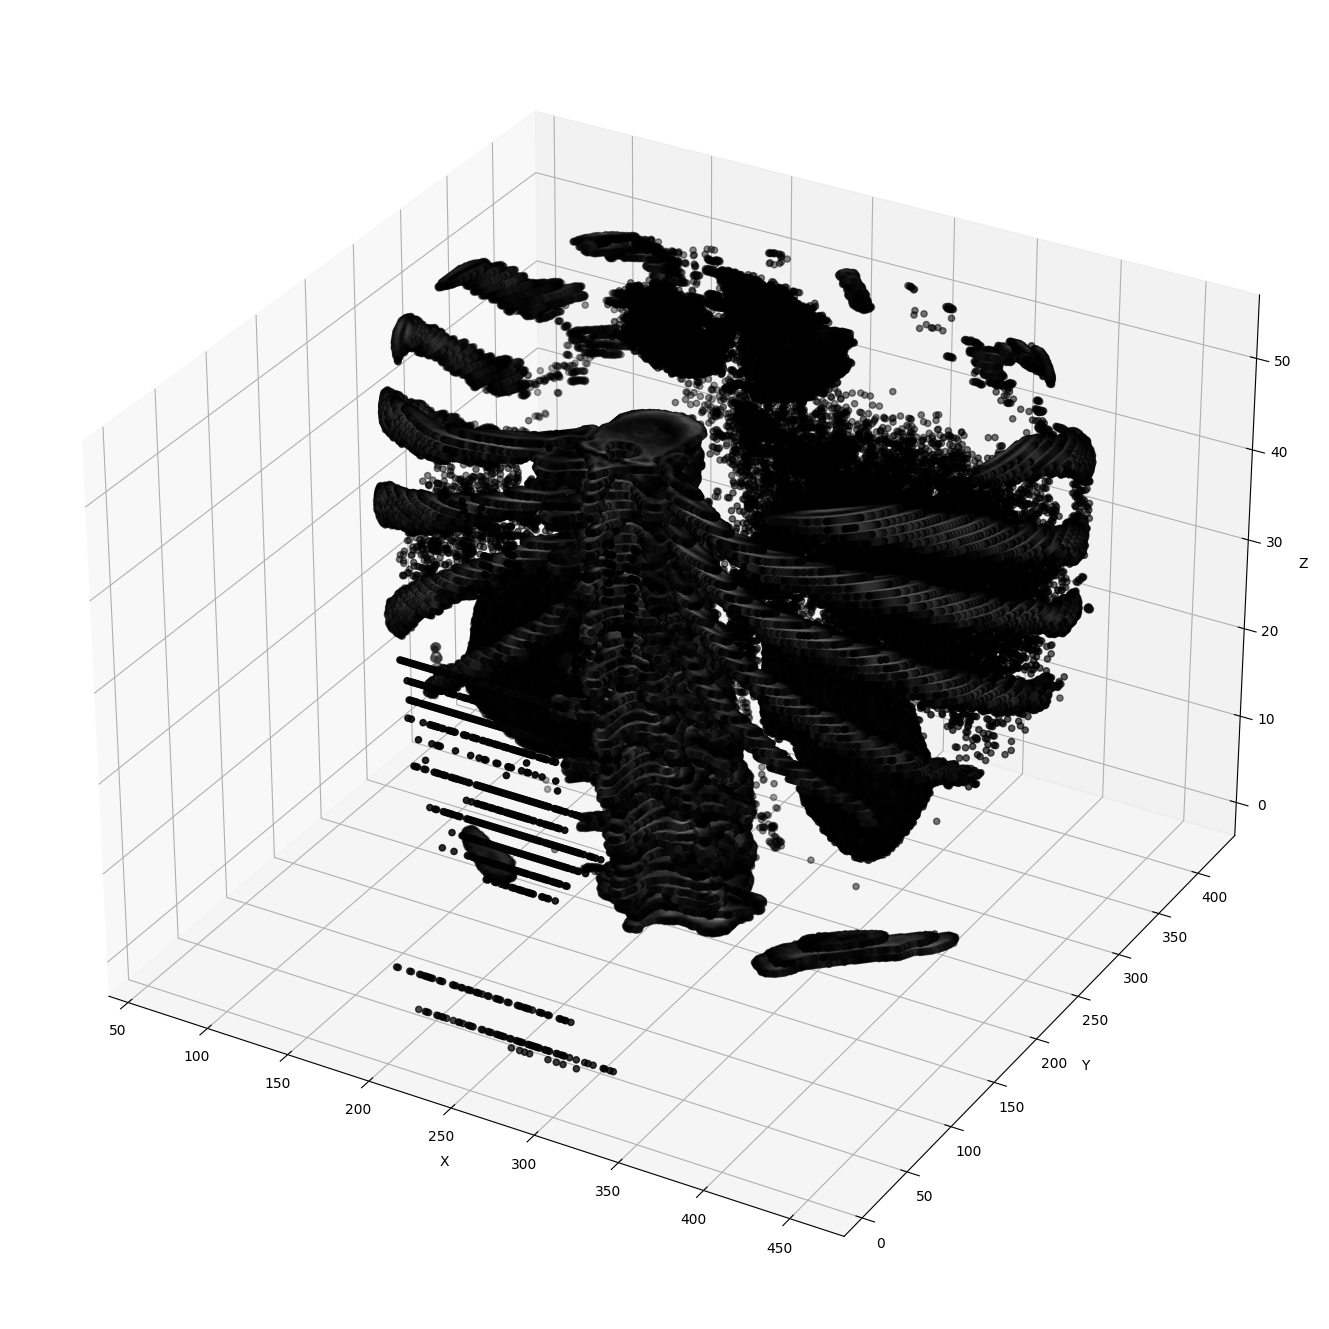

In [ ]:
import nibabel as nib
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, fixed

# Load a random file
if nii_files:
    random_file = random.choice(nii_files)
    img = nib.load(random_file)
    img_data = img.get_fdata()

    # If the data has more than 3 dimensions, we select the first volume
    if img_data.ndim > 3:
        img_data = img_data[..., 0]

    # Function to plot 3D volume
    def plot_3d_volume(threshold, figsize_x, figsize_y):
        vol = img_data
        fig = plt.figure(figsize=(figsize_x, figsize_y))
        ax = fig.add_subplot(111, projection='3d')

        if threshold is not None:
            vol = np.where(vol > threshold, vol, 0)

        # Extract the non-zero voxel coordinates
        coords = np.nonzero(vol)

        # Plot the 3D scatter plot
        ax.scatter(coords[0], coords[1], coords[2], zdir='z', c=vol[coords], cmap='gray')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.show()

    # Interactive plot
    interact(plot_3d_volume,
             threshold=widgets.FloatSlider(min=0, max=np.max(img_data), step=0.1, value=0),
             figsize_x=widgets.FloatSlider(min=5, max=20, step=1, value=10),
             figsize_y=widgets.FloatSlider(min=5, max=20, step=1, value=10))

    # Print header information
    print(img.header)
else:
    print("No .nii.gz files found in the directory.")


In [ ]:
import nibabel as nib
import os
import numpy as np
from collections import defaultdict

# Function to summarize header information
def summarize_headers(nii_files):
    header_summary = []
    for file in nii_files:
        try:
            img = nib.load(file)
            header_info = {
                'File': file,
                'Dimensions': img.header.get_data_shape(),
                'Voxel Sizes': img.header.get_zooms(),
                'Data Type': img.header.get_data_dtype(),
                'Intent': img.header.get_intent(),
                'Q Form Code': img.header['qform_code'],
                'S Form Code': img.header['sform_code']
                # Add more fields as needed
            }
            header_summary.append(header_info)
        except nib.filebasedimages.ImageFileError:
            print(f"Skipping invalid file: {file}")
    return header_summary

# Path to the extracted data
data_path = './Task09_Spleen/'

# Find all .nii.gz files, ignoring macOS metadata files
nii_files = [os.path.join(root, file)
             for root, _, files in os.walk(data_path)
             for file in files if file.endswith('.nii.gz') and not file.startswith('._')]

# Summarize headers
header_summary = summarize_headers(nii_files)

# Group images by Dimensions and Voxel Sizes
groups = defaultdict(list)
for info in header_summary:
    key = (info['Dimensions'], info['Voxel Sizes'])
    groups[key].append(info['File'])

# Print grouped summaries
for key, files in groups.items():
    dimensions, voxel_sizes = key
    print(f"Group: Dimensions = {dimensions}, Voxel Sizes = {voxel_sizes}")
    print(f"Number of images: {len(files)}")
    print("Files:")
    for file in files:
        print(f"  - {file}")
    print("--------------------------------------")

# Example analysis: Count unique dimensions
unique_dimensions = set(info['Dimensions'] for info in header_summary)
print(f"Unique Dimensions: {unique_dimensions}")

# Filter voxel sizes to only include those with length 3 (for 3D images)
voxel_sizes_3d = [info['Voxel Sizes'] for info in header_summary if len(info['Voxel Sizes']) == 3]

if voxel_sizes_3d:
    # Example analysis: Average voxel sizes for 3D images
    average_voxel_sizes = np.mean(voxel_sizes_3d, axis=0)
    print(f"Average Voxel Sizes: {average_voxel_sizes}")
else:
    print("No 3D images found with consistent voxel sizes.")


Group: Dimensions = (512, 512, 51), Voxel Sizes = (0.796875, 0.796875, 5.0)
Number of images: 2
Files:
  - ./Task09_Spleen/labelsTr/spleen_19.nii.gz
  - ./Task09_Spleen/imagesTr/spleen_19.nii.gz
--------------------------------------
Group: Dimensions = (512, 512, 56), Voxel Sizes = (0.740234, 0.740234, 5.0)
Number of images: 2
Files:
  - ./Task09_Spleen/labelsTr/spleen_31.nii.gz
  - ./Task09_Spleen/imagesTr/spleen_31.nii.gz
--------------------------------------
Group: Dimensions = (512, 512, 112), Voxel Sizes = (0.804688, 0.804688, 4.0)
Number of images: 2
Files:
  - ./Task09_Spleen/labelsTr/spleen_52.nii.gz
  - ./Task09_Spleen/imagesTr/spleen_52.nii.gz
--------------------------------------
Group: Dimensions = (512, 512, 93), Voxel Sizes = (0.75, 0.75, 5.0)
Number of images: 2
Files:
  - ./Task09_Spleen/labelsTr/spleen_40.nii.gz
  - ./Task09_Spleen/imagesTr/spleen_40.nii.gz
--------------------------------------
Group: Dimensions = (512, 512, 40), Voxel Sizes = (0.738281, 0.738281, 

In [ ]:
!pip install opencv-python numpy pyvirtualcam
!pip install opencv-python numpy pyvirtualcam
!sudo apt-get install v4l2loopback-dkms
!sudo modprobe v4l2loopback

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-12 dctrl-tools dkms fakeroot gcc-12 libasan8 libfakeroot libgcc-12-dev
  libtsan2
Suggested packages:
  gcc-12-locales cpp-12-doc debtags menu gcc-12-multilib gcc-12-doc
  v4l2loopback-utils
The following NEW packages will be installed:
  cpp-12 dctrl-tools dkms fakeroot gcc-12 libasan8 libfakeroot libgcc-12-dev
  libtsan2 v4l2loopback-dkms
0 upgraded, 10 newly installed, 0 to remove and 45 not upgraded.
Need to get 40.4 MB of archives.
After this operation, 139 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-12 amd64 12.3.0-1ubuntu1~22.04 [10.8 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan8 amd64 12.3.0-1ubuntu1~22.04 [2,442 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan2 amd64 12.3.0-1ubuntu1~22.04 [2,477 kB]
Ge

In [ ]:
import cv2
import numpy as np

def get_whiteboard_corners(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100)

    if lines is None:
        return None

    corners = []
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        corners.append((x1, y1))
        corners.append((x2, y2))

    return corners

def correct_perspective(frame, corners):
    rect = np.zeros((4, 2), dtype="float32")
    corners = np.array(corners)
    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]

    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]

    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(frame, M, (maxWidth, maxHeight))

    return warped

# Simulate a webcam feed in Colab (you can upload an image to test this part)
from google.colab.patches import cv2_imshow
import IPython.display

# Assuming 'frame' is your input image
frame = cv2.imread('/content/sample_image.jpg')  # replace with actual image path

corners = get_whiteboard_corners(frame)
if corners and len(corners) >= 4:
    corrected_frame = correct_perspective(frame, corners[:4])
    cv2_imshow(corrected_frame)
else:
    print("Could not detect the whiteboard corners")


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
from google.colab import files
uploaded = files.upload()

# After uploading, you can access the file name from the uploaded dictionary
image_path = list(uploaded.keys())[0]


Saving foo.png to foo.png


Saving 2019-01-16-20-18-59-886.jpg to 2019-01-16-20-18-59-886 (4).jpg


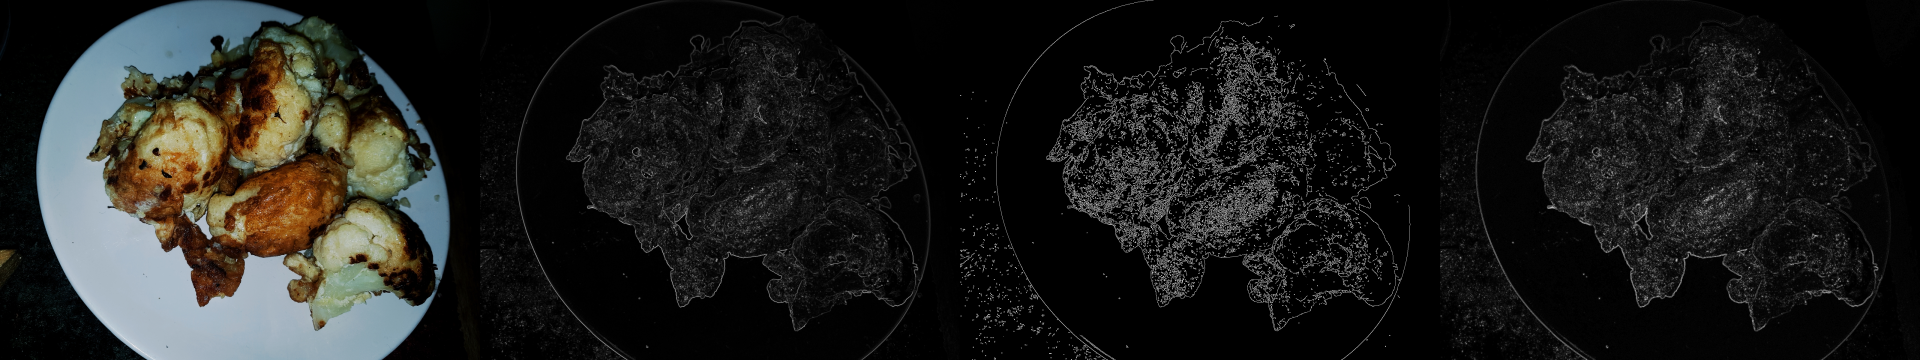

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_edges(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sobel Edge Detection
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    edges_x = cv2.filter2D(gray, cv2.CV_32F, sobel_x)
    edges_y = cv2.filter2D(gray, cv2.CV_32F, sobel_y)
    edges_sobel = cv2.magnitude(edges_x, edges_y)
    edges_sobel = cv2.normalize(edges_sobel, None, 0, 255, cv2.NORM_MINMAX)
    edges_sobel = np.uint8(edges_sobel)

    # Canny Edge Detection
    edges_canny = cv2.Canny(gray, 100, 200)

    # Laplacian of Gaussian Edge Detection
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    edges_log = cv2.Laplacian(blur, cv2.CV_16S, ksize=3)
    edges_log = cv2.convertScaleAbs(edges_log)

    return edges_sobel, edges_canny, edges_log

def show_combined_images(image, edges_sobel, edges_canny, edges_log):
    # Resize images to smaller size for display
    scale_percent = 30  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    resized_edges_sobel = cv2.resize(edges_sobel, dim, interpolation=cv2.INTER_AREA)
    resized_edges_canny = cv2.resize(edges_canny, dim, interpolation=cv2.INTER_AREA)
    resized_edges_log = cv2.resize(edges_log, dim, interpolation=cv2.INTER_AREA)

    # Convert grayscale edge images to BGR (3 channels)
    resized_edges_sobel = cv2.cvtColor(resized_edges_sobel, cv2.COLOR_GRAY2BGR)
    resized_edges_canny = cv2.cvtColor(resized_edges_canny, cv2.COLOR_GRAY2BGR)
    resized_edges_log = cv2.cvtColor(resized_edges_log, cv2.COLOR_GRAY2BGR)

    # Stack images horizontally
    combined = np.hstack((resized_image, resized_edges_sobel, resized_edges_canny, resized_edges_log))

    # Display the combined image
    cv2_imshow(combined)

# Example usage
# Upload an image
from google.colab import files
uploaded = files.upload()

# Load the uploaded image
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or unable to read.")
else:
    edges_sobel, edges_canny, edges_log = detect_edges(image)
    show_combined_images(image, edges_sobel, edges_canny, edges_log)


Saving 2019-01-16-20-18-59-886.jpg to 2019-01-16-20-18-59-886 (5).jpg


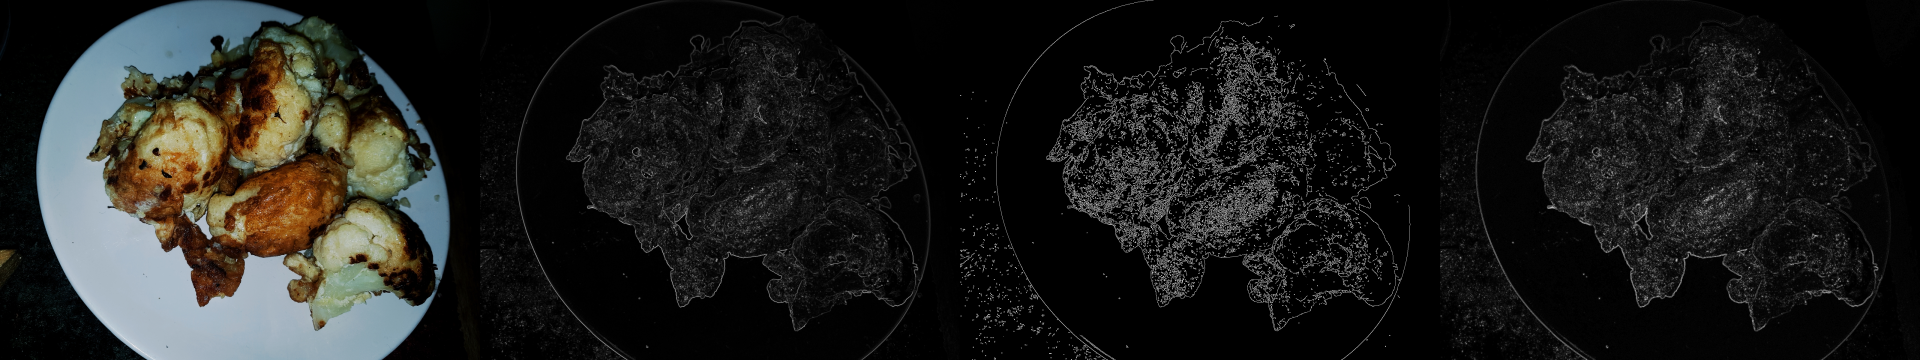

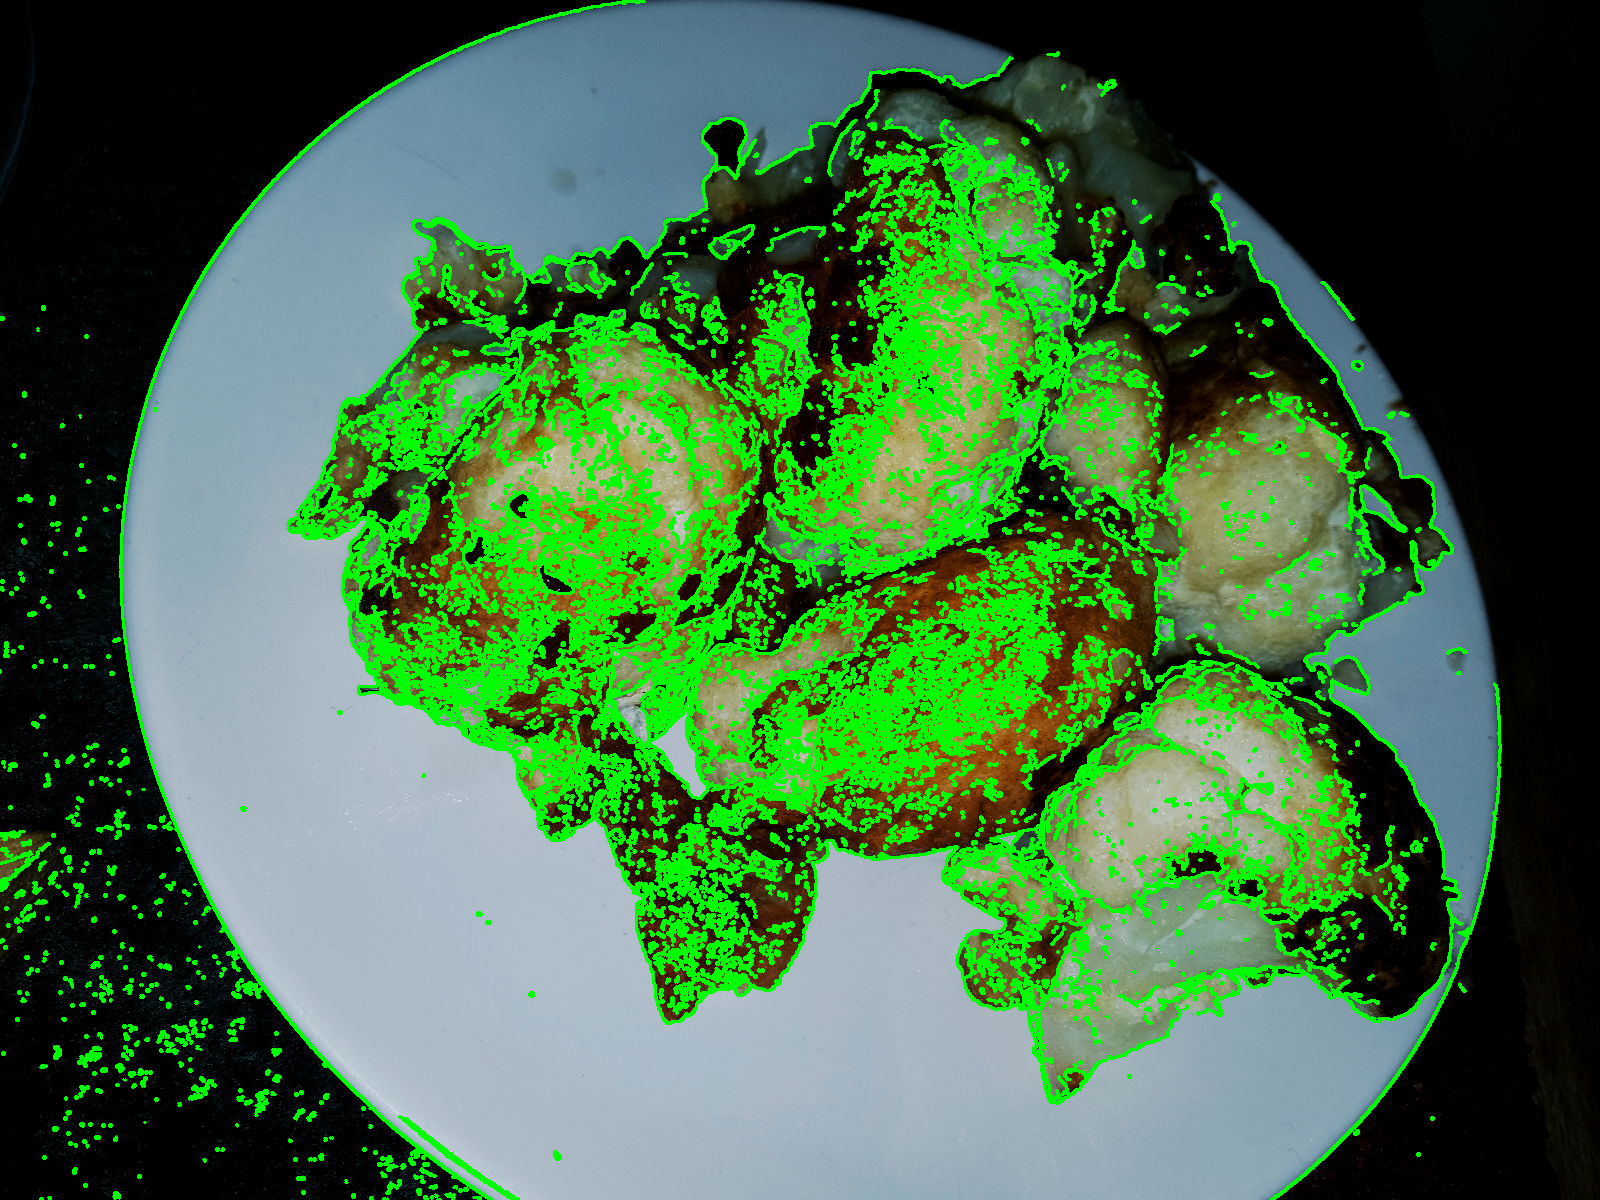

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_edges(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sobel Edge Detection
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    edges_x = cv2.filter2D(gray, cv2.CV_32F, sobel_x)
    edges_y = cv2.filter2D(gray, cv2.CV_32F, sobel_y)
    edges_sobel = cv2.magnitude(edges_x, edges_y)
    edges_sobel = cv2.normalize(edges_sobel, None, 0, 255, cv2.NORM_MINMAX)
    edges_sobel = np.uint8(edges_sobel)

    # Canny Edge Detection
    edges_canny = cv2.Canny(gray, 100, 200)

    # Laplacian of Gaussian Edge Detection
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    edges_log = cv2.Laplacian(blur, cv2.CV_16S, ksize=3)
    edges_log = cv2.convertScaleAbs(edges_log)

    return edges_sobel, edges_canny, edges_log

def show_combined_images(image, edges_sobel, edges_canny, edges_log):
    # Resize images to smaller size for display
    scale_percent = 30  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    resized_edges_sobel = cv2.resize(edges_sobel, dim, interpolation=cv2.INTER_AREA)
    resized_edges_canny = cv2.resize(edges_canny, dim, interpolation=cv2.INTER_AREA)
    resized_edges_log = cv2.resize(edges_log, dim, interpolation=cv2.INTER_AREA)

    # Convert grayscale edge images to BGR (3 channels)
    resized_edges_sobel = cv2.cvtColor(resized_edges_sobel, cv2.COLOR_GRAY2BGR)
    resized_edges_canny = cv2.cvtColor(resized_edges_canny, cv2.COLOR_GRAY2BGR)
    resized_edges_log = cv2.cvtColor(resized_edges_log, cv2.COLOR_GRAY2BGR)

    # Stack images horizontally
    combined = np.hstack((resized_image, resized_edges_sobel, resized_edges_canny, resized_edges_log))

    # Display the combined image
    cv2_imshow(combined)

def detect_and_draw_contours(image, edges):
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    return image_with_contours

# Example usage
# Upload an image
from google.colab import files
uploaded = files.upload()

# Load the uploaded image
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or unable to read.")
else:
    edges_sobel, edges_canny, edges_log = detect_edges(image)
    show_combined_images(image, edges_sobel, edges_canny, edges_log)

    image_with_contours = detect_and_draw_contours(image, edges_canny)
    cv2_imshow(image_with_contours)
